In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery

# Initialize a BigQuery client
client = bigquery.Client()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


## **1.Total number of reports by year**

How has the number of disease reports evolved over the years (2022–2024)?

In [ ]:
%%bigquery --project ba-882-group3
SELECT
    r.mmwr_year,
    COUNT(DISTINCT w.report_id) AS distinct_reports,
    SUM(w.current_week) AS total_cases
FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN
    `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
GROUP BY
    r.mmwr_year
ORDER BY
    r.mmwr_year

Query is running:   0%|          |

Downloading:   0%|          |

,mmwr_year,distinct_reports,total_cases
0,2022,3565,12227115
1,2023,148,1001438
2,2024,63,607624


From the report table, we found that 2022 has the most number of disease outbreak entries.

## **2.Which diseases are being reported the most?**

What are the top 5 most reported diseases across all locations?

In [ ]:
%%bigquery df --project ba-882-group3
WITH disease_totals AS (
  SELECT
    d.disease_name,
    SUM(w.current_week) AS total_cases
  FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN
    `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  GROUP BY
    d.disease_name
)
SELECT
  disease_name,
  total_cases
FROM
  disease_totals
ORDER BY
  total_cases DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,disease_name,total_cases
0,Chlamydia trachomatis infection,10878111
1,Gonorrhea,3853619
2,Campylobacteriosis,333540
3,Salmonellosis (excluding Salmonella Typhi infe...,155483
4,"Invasive pneumococcal disease, all ages, Confi...",118671
5,"Syphilis, Primary and secondary",88979
6,Coccidioidomycosis,79558
7,Giardiasis,67884
8,Shigellosis,55217
9,Cryptosporidiosis,44094


In [ ]:
disease_name_mapping = {
    'Chlamydia trachomatis infection': 'Chlamydia',
    'Gonorrhea': 'Gonorrhea',
    'Campylobacteriosis': 'Campylobacter',
    'Salmonellosis (excluding Salmonella Typhi infection and Salmonella Paratyphi infection)': 'Salmonellosis',
    'Invasive pneumococcal disease, all ages, Confirmed': 'Pneumococcal Disease',
    'Shiga toxin-producing Escherichia coli (STEC)': 'STEC E-coli',
    'Haemophilus influenzae, invasive disease, All ages, all serotypes': 'Haemophilus influenzae',
}

# Replace the long names with shorter ones
df['disease_name'] = df['disease_name'].replace(disease_name_mapping)


In [ ]:
from wordcloud import WordCloud

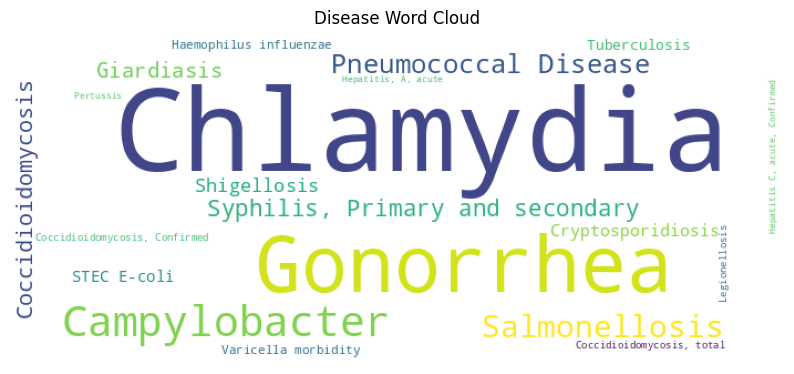

In [ ]:
# Create a dictionary of disease names and their total cases
word_freq = dict(zip(df['disease_name'], df['total_cases']))

# Create and generate a word cloud image
wordcloud = WordCloud(width=700, height=300, background_color='white').generate_from_frequencies(word_freq)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Disease Word Cloud')
plt.show()

WE can see that chlamydia is a disease that has been reported the highhest throughout the dataset.

## **3. Diseases with highest number of reporting for every year**

In [ ]:
%%bigquery --project ba-882-group3
WITH yearly_top_disease AS (
  SELECT
    r.mmwr_year,
    d.disease_name,
    SUM(w.current_week) AS total_cases,
    ROW_NUMBER() OVER (PARTITION BY r.mmwr_year ORDER BY SUM(w.current_week) DESC) AS rank
  FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN
    `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  JOIN
    `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
  GROUP BY
    r.mmwr_year, d.disease_name
)
SELECT
  mmwr_year,
  disease_name,
  total_cases
FROM
  yearly_top_disease
WHERE
  rank = 1
ORDER BY
  mmwr_year DESC

Query is running:   0%|          |

Downloading:   0%|          |

,mmwr_year,disease_name,total_cases
0,2024,Chlamydia trachomatis infection,227296
1,2023,Chlamydia trachomatis infection,588675
2,2022,Chlamydia trachomatis infection,8326897


We see that every year chlamydia is a disease that gets reported the most.

## **4. What is the geographic distribution of the most reported diseases in 2024?**

In [ ]:
%%bigquery --project ba-882-group3

WITH disease_counts AS (
  SELECT
    d.disease_name,
    l.states,
    SUM(w.current_week) AS total_cases,
    ROW_NUMBER() OVER (ORDER BY SUM(w.current_week) DESC) AS rank
  FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN
    `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  JOIN
    `ba-882-group3.NNDSS_Dataset.Location` l ON w.location_id = l.location_id
  JOIN
    `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
  WHERE
    r.mmwr_year = 2024
  GROUP BY
    d.disease_name, l.states
)
SELECT
  disease_name,
  states,
  total_cases
FROM
  disease_counts
WHERE
  rank = 1
ORDER BY
  total_cases DESC

Query is running:   0%|          |

Downloading:   0%|          |

,disease_name,states,total_cases
0,Chlamydia trachomatis infection,FLORIDA,3446


We see that florida has the highest number of chlamydia reportings this year

## **5. States with the highest disease reports**

In [ ]:
%%bigquery df --project ba-882-group3
SELECT
    l.states, SUM(w.current_week) AS total_cases
FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN
    `ba-882-group3.NNDSS_Dataset.Location` l ON w.location_id = l.location_id
GROUP BY
    l.states
ORDER BY
    total_cases DESC
LIMIT 11;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,states,total_cases
0,,350088
1,FLORIDA,28778
2,CALIFORNIA,20518
3,GEORGIA,20295
4,NEW YORK,14636
5,SOUTH CAROLINA,13486
6,VIRGINIA,12825
7,ARIZONA,10394
8,MISSOURI,9767
9,PENNSYLVANIA,9338


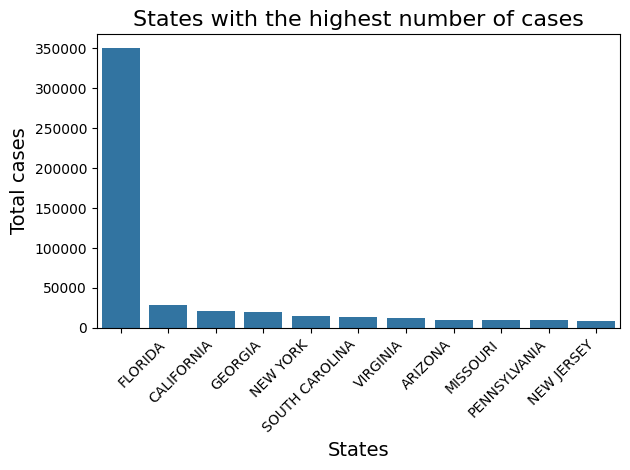

In [ ]:
sns.barplot(x='states', y='total_cases', data=df)

plt.xticks(rotation=45, ha='right')
plt.title('States with the highest number of cases', fontsize=16)
plt.xlabel('States', fontsize=14)
plt.ylabel('Total cases', fontsize=14)
plt.tight_layout()
plt.show()

We see that through out florida has the highest number of reportings followed by california georgia etc.

## **6. How do the cumulative year-to-date (YTD) reports in 2024 compare with the previous year?**

In [ ]:
%%bigquery df--project ba-882-group3
WITH current_year AS (
  SELECT
    d.disease_name,
    SUM(w.cumulative_ytd) AS ytd_2024
  FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN
    `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  JOIN
    `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
  WHERE
    r.mmwr_year = 2024
  GROUP BY
    d.disease_name
),
previous_year AS (
  SELECT
    d.disease_name,
    SUM(w.cumulative_ytd_previous) AS ytd_2023
  FROM
    `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN
    `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  JOIN
    `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
  WHERE
    r.mmwr_year = 2023
  GROUP BY
    d.disease_name
)
SELECT
  cy.disease_name,
  cy.ytd_2024,
  py.ytd_2023,
  cy.ytd_2024 - py.ytd_2023 AS ytd_difference,
  CASE
    WHEN py.ytd_2023 > 0 THEN ROUND((cy.ytd_2024 - py.ytd_2023) / py.ytd_2023 * 100, 2)
    ELSE NULL
  END AS percent_change
FROM
  current_year cy
JOIN
  previous_year py ON cy.disease_name = py.disease_name
ORDER BY
  cy.ytd_2024 DESC -- Arrange by the number of cases in descending order
LIMIT 15

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,disease_name,ytd_2024,ytd_2023,ytd_difference,percent_change
0,Chlamydia trachomatis infection,11551951,20482604,-8930653,-43.60
1,Gonorrhea,5051265,4642383,408882,8.81
2,Campylobacteriosis,604439,814882,-210443,-25.82
3,Salmonellosis (excluding Salmonella Typhi infe...,270232,707808,-437576,-61.82
4,"Syphilis, Primary and secondary",207331,510590,-303259,-59.39
5,"Coccidioidomycosis, total",205652,144464,61188,42.36
6,"Coccidioidomycosis, Confirmed",203132,144464,58668,40.61
7,"Invasive pneumococcal disease, all ages, Confi...",194728,168371,26357,15.65
8,Giardiasis,153292,85674,67618,78.92
9,Shigellosis,133139,145859,-12720,-8.72


In [ ]:
disease_name_mapping = {
    'Chlamydia trachomatis infection': 'Chlamydia',
    'Gonorrhea': 'Gonorrhea',
    'Hepatitis C, chronic, Confirmed' : 'Hepatitis C-confirmed',
    'Hepatitis C, chronic, Probable': 'Hepatitis C-probable',
    'Campylobacteriosis': 'Campylobacter',
    'Hepatitis B, chronic, Probable' : 'Hepatitis B-probable',
    'Coccidioidomycosis, total' : 'Valley fever-total',
    'Coccidioidomycosis, Confirmed' : 'Valey fever-confirmed',
    'Salmonellosis (excluding Salmonella Typhi infection and Salmonella Paratyphi infection)': 'Salmonellosis',
    'Invasive pneumococcal disease, all ages, Confirmed': 'Pneumococcal Disease',
    'Syphilis, Primary and secondary': 'Syphilis',
    'Haemophilus influenzae, invasive disease, All ages, all serotypes': 'Haemophilus influenzae',
    'Shiga toxin-producing Escherichia coli (STEC)': 'STEC E.coli'
}

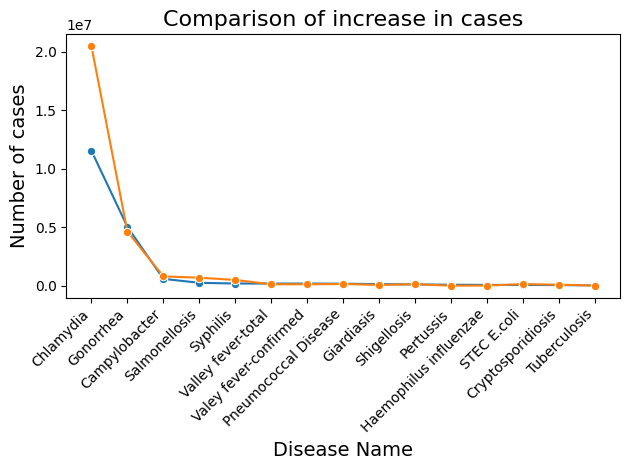

In [ ]:
df['disease_name'] = df['disease_name'].replace(disease_name_mapping)
sns.lineplot(x='disease_name', y='ytd_2024', data=df, marker = 'o')

sns.lineplot(x='disease_name', y='ytd_2023', data=df, marker = 'o')

plt.xticks(rotation=45, ha='right')
plt.title('Comparison of increase in cases', fontsize=16)
plt.xlabel('Disease Name', fontsize=14)
plt.ylabel('Number of cases', fontsize=14)
plt.tight_layout()
plt.show()

We can see that the most reported disease chlamydia decreased by 43.6% in 2024 compared to 2023. Similarly, giardiasis is a disease which increased 78% in 2024 compared to 2023.

## **7. Which states have the highest number of cumulative cases this year in 2024?**

In [ ]:
%%bigquery df --project ba-882-group3
SELECT l.states, SUM(w.cumulative_ytd) AS total_ytd_cases
FROM ba-882-group3.NNDSS_Dataset.Weekly_Data w
JOIN ba-882-group3.NNDSS_Dataset.Location l
ON w.location_id = l.location_id
JOIN ba-882-group3.NNDSS_Dataset.Report r
ON w.report_id = r.report_id
WHERE r.mmwr_year = 2024
GROUP BY l.states
ORDER BY total_ytd_cases DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,states,total_ytd_cases
0,TEXAS,200992
1,FLORIDA,188561
2,CALIFORNIA,157529
3,SOUTH CAROLINA,62801
4,ILLINOIS,61823
5,VIRGINIA,60969
6,NEW JERSEY,58998
7,ARIZONA,58301
8,NORTH CAROLINA,45435
9,MARYLAND,40665


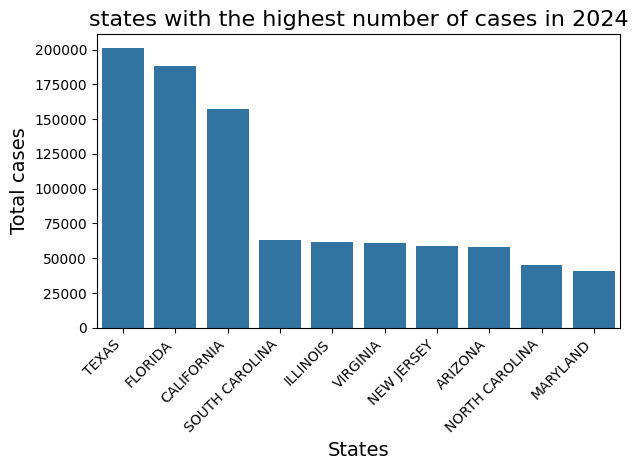

In [ ]:
sns.barplot(x='states', y='total_ytd_cases', data=df)

plt.xticks(rotation=45, ha='right')
plt.title('states with the highest number of cases in 2024', fontsize=16)
plt.xlabel('States', fontsize=14)
plt.ylabel('Total cases', fontsize=14)
plt.tight_layout()
plt.show()

Even though florida has the most number of reported diseases. In 2024, texas surpassed florida with 200992 cases and florida having 188561 disease reportings.

## **8. Which week had the highest number of reported cases for each disease this year?**

In [ ]:
%%bigquery --project ba-882-group3

WITH ranked_weeks AS (
  SELECT DISTINCT(d.disease_name), r.mmwr_week, SUM(w.current_week) AS weekly_cases,
         ROW_NUMBER() OVER (PARTITION BY d.disease_id ORDER BY SUM(w.current_week) DESC) AS rn
  FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  JOIN `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
  WHERE r.mmwr_year = 2024
  GROUP BY d.disease_name, r.mmwr_week, d.disease_id
)
SELECT disease_name, mmwr_week AS peak_week, weekly_cases AS peak_cases
FROM ranked_weeks
WHERE rn = 1
ORDER BY peak_cases DESC

Query is running:   0%|          |

Downloading:   0%|          |

,disease_name,peak_week,peak_cases
0,Chlamydia trachomatis infection,28,60762
1,Chlamydia trachomatis infection,30,56674
2,Chlamydia trachomatis infection,26,56130
3,Gonorrhea,28,22200
4,Gonorrhea,30,18748
...,...,...,...
384,"Viral hemorrhagic fevers, Sabia virus",1,0
385,"Arboviral diseases, Chikungunya virus disease",26,0
386,Hansen's disease,2,0
387,Novel Influenza A virus infections,29,0


We can see that for 2024 week 28 both Chamydia and Gonorrhea had the highest number of reportings, that is in the month of July.

## **9. What are the most prevalent diseases in each state?**

In [ ]:
%%bigquery --project ba-882-group3

WITH state_disease_rank AS (
  SELECT l.states, d.disease_name, SUM(w.current_week) AS total_cases,
         ROW_NUMBER() OVER (PARTITION BY l.states ORDER BY SUM(w.current_week) DESC) AS rn
  FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
  JOIN `ba-882-group3.NNDSS_Dataset.Location` l ON w.location_id = l.location_id
  JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
  GROUP BY l.states, d.disease_name
)
SELECT states, disease_name, total_cases
FROM state_disease_rank
WHERE rn = 1
ORDER BY total_cases DESC

Query is running:   0%|          |

Downloading:   0%|          |

,states,disease_name,total_cases
0,,Chlamydia trachomatis infection,239808
1,FLORIDA,Chlamydia trachomatis infection,16419
2,GEORGIA,Chlamydia trachomatis infection,16078
3,CALIFORNIA,Chlamydia trachomatis infection,15186
4,NEW YORK,Chlamydia trachomatis infection,10605
5,SOUTH CAROLINA,Chlamydia trachomatis infection,9613
6,VIRGINIA,Chlamydia trachomatis infection,8514
7,PENNSYLVANIA,Chlamydia trachomatis infection,7664
8,NEW JERSEY,Chlamydia trachomatis infection,6060
9,COLORADO,Chlamydia trachomatis infection,5907


We can see that chlamydia is still the disease that gets reported the most in majority fo the states.

## **10. What is the average number of cases per week for each disease?**

In [ ]:
%%bigquery df --project ba-882-group3

SELECT d.disease_name, AVG(w.current_week) AS avg_weekly_cases
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
GROUP BY d.disease_name
ORDER BY avg_weekly_cases DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,disease_name,avg_weekly_cases
0,Chlamydia trachomatis infection,553.030554
1,Gonorrhea,202.779362
2,"Hepatitis C, chronic, Confirmed",46.400000
3,"Hepatitis C, chronic, Probable",45.628571
4,Campylobacteriosis,17.142417
5,"Hepatitis B, chronic, Probable",14.400000
6,"Coccidioidomycosis, total",13.564286
7,"Coccidioidomycosis, Confirmed",13.410092
8,Salmonellosis (excluding Salmonella Typhi infe...,8.283591
9,"Invasive pneumococcal disease, all ages, Confi...",6.169214


In [ ]:
disease_name_mapping = {
    'Chlamydia trachomatis infection': 'Chlamydia',
    'Gonorrhea': 'Gonorrhea',
    'Hepatitis C, chronic, Confirmed' : 'Hepatitis C-confirmed',
    'Hepatitis C, chronic, Probable': 'Hepatitis C-probable',
    'Campylobacteriosis': 'Campylobacter',
    'Hepatitis B, chronic, Probable' : 'Hepatitis B-probable',
    'Coccidioidomycosis, total' : 'Valley fever-total',
    'Coccidioidomycosis, Confirmed' : 'Valey fever-confirmed',
    'Salmonellosis (excluding Salmonella Typhi infection and Salmonella Paratyphi infection)': 'Salmonellosis',
    'Invasive pneumococcal disease, all ages, Confirmed': 'Pneumococcal Disease'
}

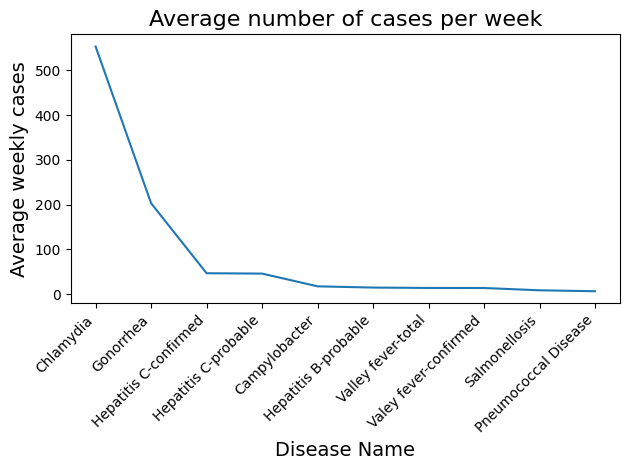

In [ ]:
df['disease_name'] = df['disease_name'].replace(disease_name_mapping)
# df['disease_name_wrapped'] = df['disease_name'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=25)))

sns.lineplot(x='disease_name', y='avg_weekly_cases', data=df)

plt.xticks(rotation=45, ha='right')
plt.title('Average number of cases per week', fontsize=16)
plt.xlabel('Disease Name', fontsize=14)
plt.ylabel('Average weekly cases', fontsize=14)
plt.tight_layout()
plt.show()

We see from the graph that in average there are 553 average weekly chlamydia cases reporting and 202 gonorrhea reporings. we also noticed a sharp drop of the curve.

## **11. Which locations have shown the highest increase in cases compared to the previous year?**

In [ ]:
%%bigquery df --project ba-882-group3

SELECT l.location_name,
       SUM(w.cumulative_ytd) AS current_ytd,
       SUM(w.cumulative_ytd_previous) AS previous_ytd,
       (SUM(w.cumulative_ytd) - SUM(w.cumulative_ytd_previous)) AS case_increase
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN `ba-882-group3.NNDSS_Dataset.Location` l ON w.location_id = l.location_id
JOIN `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
WHERE r.mmwr_year = 2024
GROUP BY l.location_name
ORDER BY case_increase DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,location_name,current_ytd,previous_ytd,case_increase
0,VIRGINIA,60969,57814,3155
1,ARIZONA,58301,55628,2673
2,SOUTH CAROLINA,62801,60435,2366
3,FLORIDA,188561,186527,2034
4,MAINE,3547,2727,820
5,OREGON,30366,29590,776
6,U.S. VIRGIN ISLANDS,90,4,86
7,DELAWARE,4949,4866,83
8,COLORADO,242,201,41
9,VERMONT,2552,2513,39


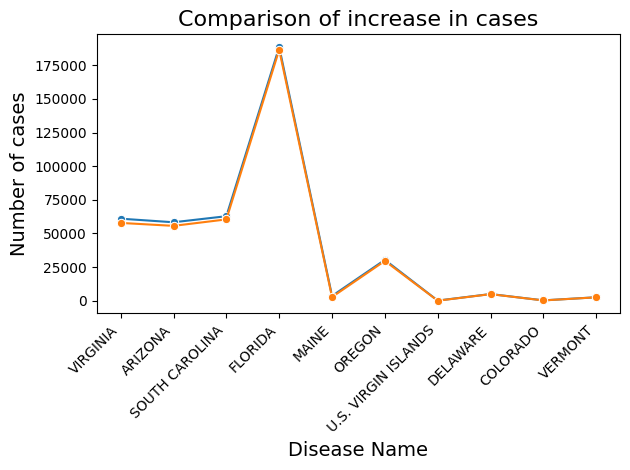

In [ ]:
sns.lineplot(x='location_name', y='current_ytd', data=df, marker = 'o')

sns.lineplot(x='location_name', y='previous_ytd', data=df, marker = 'o')

plt.xticks(rotation=45, ha='right')
plt.title('Comparison of increase in cases', fontsize=16)
plt.xlabel('Disease Name', fontsize=14)
plt.ylabel('Number of cases', fontsize=14)
plt.tight_layout()
plt.show()

We noticed that Virginia had the highest number of increase in overall disease reporting in comparison to last year with 3155 increase in cases, followed b arizona with 263 increase in cases

## **12. How does the spread of a specific disease change across different longitudes and latitudes?**

In [ ]:
%%bigquery df --project ba-882-group3

SELECT l.longitude, l.latitude, d.disease_name, SUM(w.current_week) AS total_cases
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN `ba-882-group3.NNDSS_Dataset.Location` l ON w.location_id = l.location_id
JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
WHERE d.disease_name = 'Chlamydia trachomatis infection'
GROUP BY l.longitude, l.latitude, d.disease_name
ORDER BY total_cases DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head(5)

,longitude,latitude,disease_name,total_cases
0,NaN,NaN,Chlamydia trachomatis infection,239922
1,-83.426574,32.638481,Chlamydia trachomatis infection,12426
2,-121.490860,38.579440,Chlamydia trachomatis infection,10310
3,-81.688649,28.566045,Chlamydia trachomatis infection,6588
4,-82.420978,28.260731,Chlamydia trachomatis infection,6588


In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        size="total_cases",
                        color="total_cases",
                        hover_name="disease_name",
                        zoom=3,
                        mapbox_style="open-street-map")

# Update the layout
fig.update_layout(title='Chlamydia trachomatis infection cases by location')

# Show the map
fig.show()

##Comparison of Current YTD to Previous YTD
## 12. Compare the current year-to-date totals with the previous year's YTD to see where significant changes have occurred:

In [ ]:
%%bigquery --project ba-882-group3

SELECT location_id, location, disease_id,
       SUM(cumulative_ytd) AS current_ytd,
       SUM(cumulative_ytd_previous) AS previous_ytd,
       SUM(cumulative_ytd) - SUM(cumulative_ytd_previous) AS ytd_difference
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data`
GROUP BY location_id, disease_id
ORDER BY ytd_difference DESC;


Executing query with job ID: 3d99d4a0-1eab-4563-87ab-be5f37e56ded
Query executing: 0.59s


ERROR:
 400 Unrecognized name: location; Did you mean location_id? at [1:21]; reason: invalidQuery, location: query, message: Unrecognized name: location; Did you mean location_id? at [1:21]

Location: US
Job ID: 3d99d4a0-1eab-4563-87ab-be5f37e56ded



## 13. Identify Locations with High Weekly Peaks

In [ ]:
%%bigquery --project ba-882-group3

SELECT location_id, disease_id, MAX(previous_52_week_max) AS highest_weekly_peak
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data`
GROUP BY location_id, disease_id
ORDER BY highest_weekly_peak DESC
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

,location_id,disease_id,highest_weekly_peak
0,9196755402,3956250353,37668
1,7579666890,3956250353,37568
2,6901098583,1183760265,35268
3,2242394577,3368308971,35226
4,790388030,1183760265,35224
5,6692635258,3368308971,35182
6,1120721739,1870756027,35160
7,2209655770,1870756027,35117
8,2617617423,7417997090,33169
9,2012268080,590264736,33085


##Total Cases Per Year by State

In [ ]:
%%bigquery --project ba-882-group3

SELECT mmwr_year, states, COUNT(*) AS total_cases
FROM `ba-882-group3.NNDSS_Dataset.Report`
WHERE mmwr_year BETWEEN 2022 AND 2024 AND states != 'TOTAL'
GROUP BY mmwr_year, states
ORDER BY mmwr_year, total_cases DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,mmwr_year,states,total_cases
0,2022,NEW YORK CITY,26972
1,2022,OHIO,26971
2,2022,NEW YORK,26970
3,2022,ILLINOIS,26970
4,2022,WEST NORTH CENTRAL,26970
...,...,...,...
202,2024,OKLAHOMA,1117
203,2024,KENTUCKY,1116
204,2024,NORTH CAROLINA,1116
205,2024,EAST SOUTH CENTRAL,1116


In 2022, new york had the highest number of reportings.

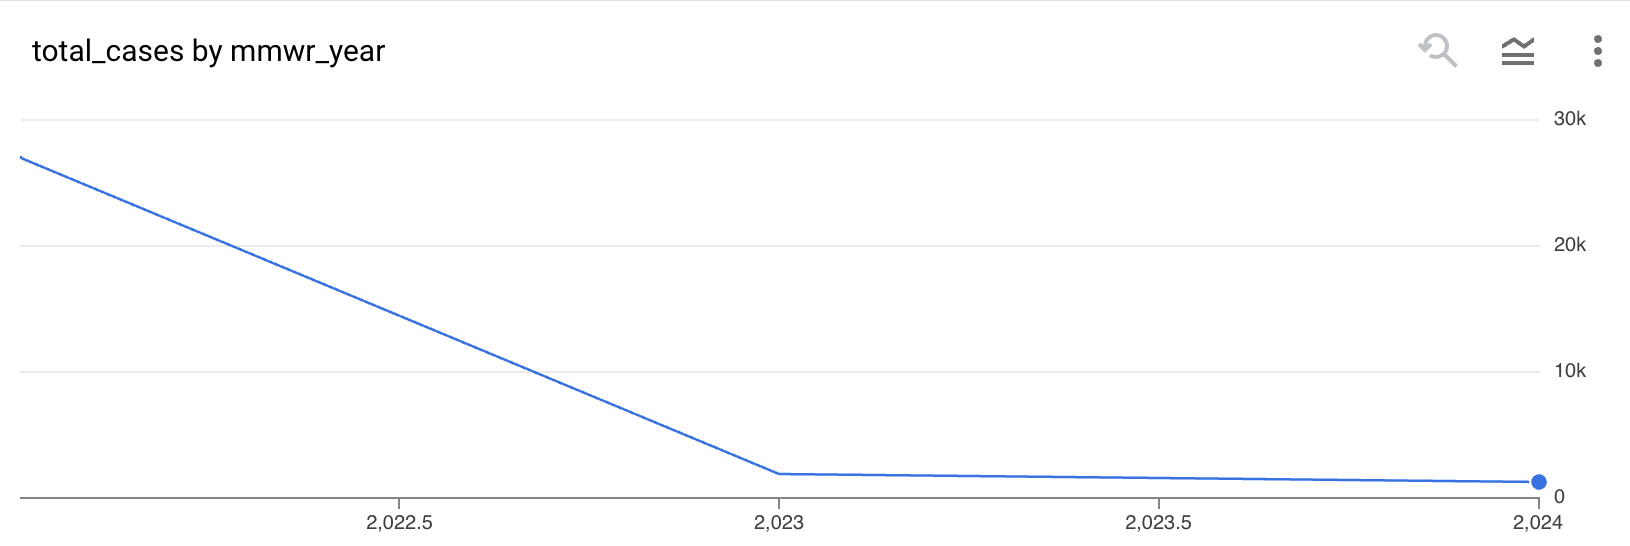

##Statistics on the number of Mpox reports by region in 2024

In [ ]:
%%bigquery df --project ba-882-group3

SELECT
    CASE
        WHEN states IN ('NEW YORK', 'NEW YORK CITY', 'VERMONT', 'MAINE', 'MASSACHUSETTS', 'NEW HAMPSHIRE', 'RHODE ISLAND', 'CONNECTICUT', 'NEW JERSEY'
        , 'DELAWARE', 'MARYLAND' ) THEN 'Northeast'
        WHEN states IN ('OHIO', 'INDIANA', 'ILLINOIS', 'MICHIGAN', 'INDIANA', 'IOWA', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA',
         'SOUTH DAKOTA', 'WISCONSIN') THEN 'Midwest'
        WHEN states IN ('CALIFORNIA', 'OREGON', 'WASHINGTON') THEN 'West'
        WHEN states IN ('TEXAS', 'ALABAMA','GEORGIA', 'FLORIDA', 'VIRGINIA', 'NORTH CAROLINA', 'SOUTH CAROLINA') THEN 'South'
        ELSE 'Other'
    END AS region,
    COUNT(*) AS total_reports
FROM `ba-882-group3.NNDSS_Dataset.Report`
WHERE mmwr_year = 2024 AND states != 'TOTAL' AND label = 'Mpox'
GROUP BY region
ORDER BY total_reports DESC;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,region,total_reports
0,Other,396
1,Midwest,132
2,Northeast,121
3,South,77
4,West,33


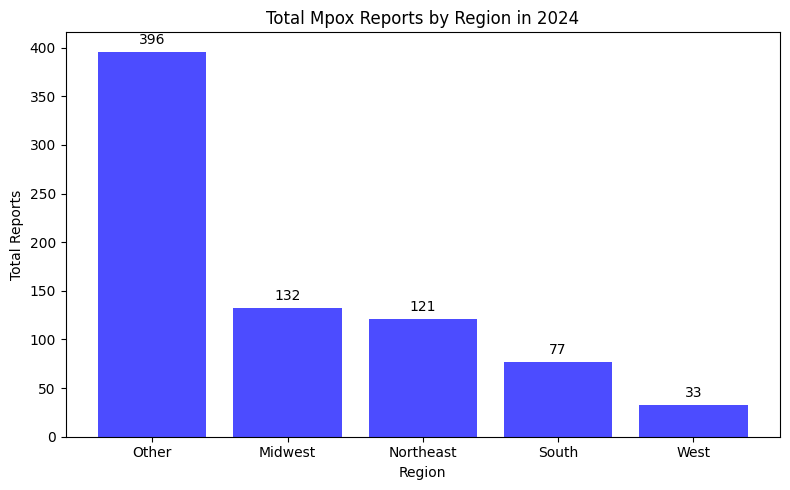

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df['region'], df['total_reports'], color='blue', alpha=0.7)

plt.title('Total Mpox Reports by Region in 2024')
plt.xlabel('Region')
plt.ylabel('Total Reports')


for index, value in enumerate(df['total_reports']):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


We can see that other region of US had more reportings of Mpox followed by midwest and west coast had the lowest reporting of MPOX

For chlamydia

In [ ]:
%%bigquery df --project ba-882-group3

SELECT
    CASE
        WHEN states IN ('NEW YORK', 'NEW YORK CITY', 'VERMONT', 'MAINE', 'MASSACHUSETTS', 'NEW HAMPSHIRE', 'RHODE ISLAND', 'CONNECTICUT', 'NEW JERSEY'
        , 'DELAWARE', 'MARYLAND' ) THEN 'Northeast'
        WHEN states IN ('OHIO', 'INDIANA', 'ILLINOIS', 'MICHIGAN', 'INDIANA', 'IOWA', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA',
         'SOUTH DAKOTA', 'WISCONSIN') THEN 'Midwest'
        WHEN states IN ('CALIFORNIA', 'OREGON', 'WASHINGTON') THEN 'West'
        WHEN states IN ('TEXAS', 'ALABAMA','GEORGIA', 'FLORIDA', 'VIRGINIA', 'NORTH CAROLINA', 'SOUTH CAROLINA') THEN 'South'
        ELSE 'Other'
    END AS region,
    SUM(w.current_week)  AS total_reports
# FROM `ba-882-group3.NNDSS_Dataset.Report`
FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
JOIN `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
WHERE d.disease_name = 'Chlamydia trachomatis infection' AND mmwr_year = 2024 AND states != 'TOTAL'
#AND label = 'Chlamydia trachomatis infection'
GROUP BY region
ORDER BY total_reports DESC;


# SELECT SUM(w.current_week) AS total_cases
# FROM `ba-882-group3.NNDSS_Dataset.Weekly_Data` w
# JOIN `ba-882-group3.NNDSS_Dataset.Disease` d ON w.disease_id = d.disease_id
# JOIN `ba-882-group3.NNDSS_Dataset.Report` r ON w.report_id = r.report_id
# WHERE d.disease_name = 'Chlamydia trachomatis infection'
#   AND r.mmwr_year = 2024

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,region,total_reports
0,West,60762
1,Other,56674
2,Midwest,56130
3,Northeast,53730


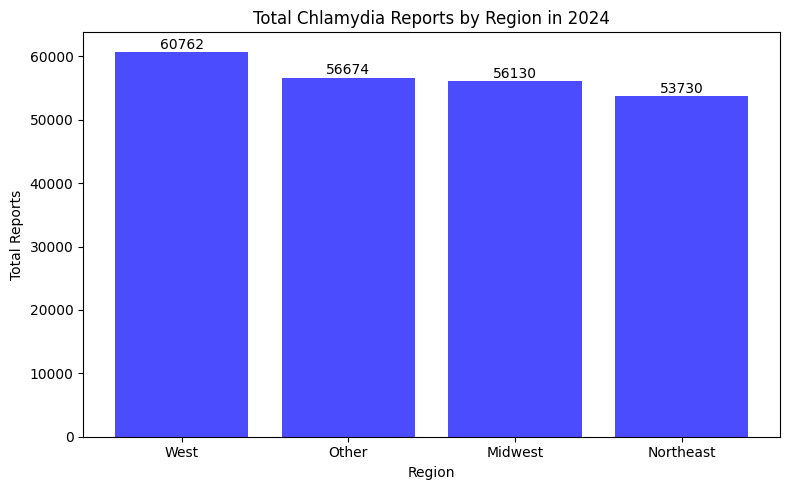

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df['region'], df['total_reports'], color='blue', alpha=0.7)

plt.title('Total Chlamydia Reports by Region in 2024')
plt.xlabel('Region')
plt.ylabel('Total Reports')


for index, value in enumerate(df['total_reports']):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

West coast had the highest number of chlamydia repotings of 60k cases.